# LangGraph 챗봇에서 도구 사용하기

In [1]:
!pip install langchain-tavily

In [5]:
from dotenv import load_dotenv
load_dotenv()

True

### 도구 tools 정의

In [6]:
from langchain_tavily import TavilySearch

tavily_tool = TavilySearch(max_results=2)

tavily_tool.invoke('랭그래프에서 노드는 무엇인가요?')

{'query': '랭그래프에서 노드는 무엇인가요?',
 'follow_up_questions': None,
 'answer': None,
 'images': [],
 'results': [{'url': 'https://blog.naver.com/pjt3591oo/223861729229?viewType=pc',
   'title': 'langgraph 소개 및 기본개념 : 네이버 블로그',
   'content': '· 노드(nodes): 그래프의 작업 단위\u200b 노드는 그래프에서 실제 작업을 수행하는 단위입니다. 각 노드는 특정 로직을 담당합니다. 작업은 LLM 호출, 데이터',
   'score': 0.99719906,
   'raw_content': None},
  {'url': 'https://tilnote.io/books/68156a4ebaa37b745385c23b/68156a79baa37b745385c298',
   'title': '3장: LangGraph의 핵심 구성요소 – 노드, 엣지, 상태 관리',
   'content': "노드는 LangGraph 워크플로우에서 하나하나의 작업 구간을 가리킨다. 말하자면 정보 추출, 외부 도구 호출, LLM 응답 생성 등 실제로 '일'이 이루어지는 지점으로, 파이썬",
   'score': 0.99242276,
   'raw_content': None}],
 'response_time': 0.0,
 'request_id': '955b779d-3316-4bcc-bf7e-1b9e9f4f846e'}

### LLM with tools

In [7]:
from langchain_openai import ChatOpenAI

llm = ChatOpenAI(model='gpt-4o')
print(type(llm))
tools = [tavily_tool]
llm_with_tools = llm.bind_tools(tools)
print(type(llm_with_tools))

<class 'langchain_openai.chat_models.base.ChatOpenAI'>
<class 'langchain_core.runnables.base.RunnableBinding'>


## 그래프 구성

### State

In [8]:
from typing import TypedDict, Annotated, List
from langgraph.graph.message import add_messages

class State(TypedDict):
    messages: Annotated[List, add_messages]

### Chatbot Node

In [9]:
def chatbot(state: State):
    response = llm_with_tools.invoke(state['messages'])
    return {'messages': [response]}

### ToolNode

- tool을 실행하고 ToolMessage를 발행하는 노드

In [10]:
import json
from langchain_core.messages import ToolMessage

class ToolNode:
    def __init__(self, tools):
        self.tools_by_name = {tool.name: tool for tool in tools}

    def __call__(self, inputs):
        """
        도구 호출을 처리하는 메서드입니다.

        Args:
            inputs (dict): 입력 상태 딕셔너리. 'messages' 키에 메시지 리스트가 포함되어야 합니다.

        Returns:
            dict: 도구 실행 결과를 담은 메시지 리스트가 포함된 딕셔너리.
                 형식: {"messages": [ToolMessage, ...]}

        Raises:
            ValueError: 입력에 메시지가 없는 경우 발생합니다.
        """
        # := 월러스 연산자: 대입과 반환을 동시에 처리
        if messages := inputs.get("messages"):
            message = messages[-1]
        else:
            raise ValueError("No messages found in inputs.")

        outputs = []
        for tool_call in message.tool_calls:
            tool_result = self.tools_by_name[tool_call['name']].invoke(tool_call['args'])
            tool_message = ToolMessage(
                content=json.dumps(tool_result),
                name=tool_call['name'],
                tool_call_id=tool_call['id'],
            )
            outputs.append(tool_message)

        return {"messages": outputs}

tool_node = ToolNode(tools)

### tool_condition 조건부엣지

In [11]:
from langgraph.graph import END

def tools_condition(state):
    if isinstance(state, list):
        ai_message = state[-1]
    elif messages := state.get("messages", []):
        ai_message = messages[-1]
    else:
        raise ValueError(f"No messages found in input state to tool_edge: {state}")
    print(f'last message has tool_calls? = {hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0}\n')

    if hasattr(ai_message, "tool_calls") and len(ai_message.tool_calls) > 0:
        return 'tools'
    return END

### 노드/엣지 정의, 컴파일

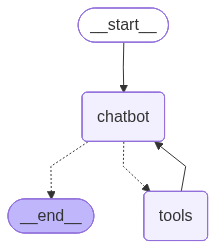

In [12]:
from langgraph.graph import StateGraph, START, END

workflow = StateGraph(State)

workflow.add_node('chatbot', chatbot)
workflow.add_node('tools', tool_node)

workflow.add_edge(START, 'chatbot')
workflow.add_edge('tools', 'chatbot')
workflow.add_conditional_edges('chatbot', tools_condition, {'tools': 'tools', END: END})

graph = workflow.compile()
graph

### 그래프 실행

In [13]:
# tool을 사용해야 하는 질문
from langchain_core.messages import HumanMessage

user_input = 'Langgraph에서 노드와 엣지를 설명해줘(주어진 tool을 필요시 활용할 것)'
initial_state = {'messages': [HumanMessage(content=user_input)]}
final_state = graph.invoke(initial_state)
final_state

last message has tool_calls? = True

last message has tool_calls? = False



{'messages': [HumanMessage(content='Langgraph에서 노드와 엣지를 설명해줘(주어진 tool을 필요시 활용할 것)', additional_kwargs={}, response_metadata={}, id='668aac4e-e778-407c-8f10-5fbcdf351539'),
  AIMessage(content='', additional_kwargs={'refusal': None}, response_metadata={'token_usage': {'completion_tokens': 24, 'prompt_tokens': 1291, 'total_tokens': 1315, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model_provider': 'openai', 'model_name': 'gpt-4o-2024-08-06', 'system_fingerprint': 'fp_cbf1785567', 'id': 'chatcmpl-CdQbN9WIiQAxm3xqcc3JWfpBV4RHI', 'service_tier': 'default', 'finish_reason': 'tool_calls', 'logprobs': None}, id='lc_run--aeff17df-93ba-49e3-ac4b-d861f5095c9f-0', tool_calls=[{'name': 'tavily_search', 'args': {'query': 'Langgraph 노드와 엣지 설명'}, 'id': 'call_CLq7Y8cXlsRtojwspTRwqVpg', 'type': 'tool_call'}], usage_metadata={'input_tokens': 12

In [14]:
final_state['messages'][-1].content

'Langgraph의 노드와 엣지는 복잡한 워크플로우를 정의하고 실행하기 위한 구성 요소입니다. Langgraph에서는 상태에 기반한 워크플로우를 구성하며, 다양한 조건부 노드와 엣지를 통해 이를 촉진합니다. 여기에서 `노드(Nodes)`는 개별 상태를 나타내며, `엣지(Edges)`는 이러한 노드 간의 전환을 정의합니다.\n\n- **노드(Nodes)**: 워크플로우 내의 특정 상태를 나타내며, 각 노드는 자체적인 입력 및 출력을 정의할 수 있습니다.\n- **엣지(Edges)**: 노드 간의 관계를 설명하며, 상태 전이와 논리적 흐름을 구현합니다.\n\nLanggraph는 이러한 구조를 효율적으로 관리하며, 체크포인터를 사용하여 상태를 추적할 수 있습니다. 이를 통해 그래프 상태 정의를 마이그레이션하기 쉽도록 설계되어 있습니다.\n\n자세한 내용은 [LangGraph Glossary](https://rudaks.tistory.com/entry/%EB%B2%88%EC%97%ADlanggraph-Contextual-Guides-LangGraph-Glossary) 및 [Node/Edge의 차이점](https://wikidocs.net/252228)에서 확인할 수 있습니다.'

In [15]:
# tool 필요없는 질문
from langchain_core.messages import HumanMessage

user_input = '인공지능이 사람의 삶을 어떻게 변화시킬까?'
initial_state = {'messages': [HumanMessage(content=user_input)]}
final_state = graph.invoke(initial_state)
final_state

last message has tool_calls? = False



{'messages': [HumanMessage(content='인공지능이 사람의 삶을 어떻게 변화시킬까?', additional_kwargs={}, response_metadata={}, id='285b7314-b96a-4171-8724-973a8b6dbb55'),
  AIMessage(content='인공지능(AI)은 다양한 방면에서 사람들의 삶을 변화시키고 있습니다. 주요한 몇 가지 방면을 소개하겠습니다:\n\n1. **자동화와 효율성**: AI는 생산과정에서 자동화를 통해 효율성을 높이고, 인간 노동의 반복적인 작업을 줄여줍니다. 이는 기업의 생산성을 향상시키고, 사람들이 더 창의적인 업무에 집중할 수 있도록 도와줍니다.\n\n2. **의료 분야 발전**: AI는 의료 진단과 치료 분야에서 혁신을 이끌고 있습니다. 예를 들어, AI는 의료 영상을 분석하여 질병의 초기 징후를 신속하게 찾아내거나, 맞춤형 치료 계획을 수립하는 데 활용될 수 있습니다.\n\n3. **개인화된 경험**: AI는 사용자의 취향과 행동을 분석하여 개인화된 서비스와 제품을 제공합니다. 이는 전자상거래, 미디어 콘텐츠 추천, 고객 서비스 등 다양한 분야에서 사용됩니다.\n\n4. **교통과 물류**: AI는 자율 주행 차량 및 스마트 물류 시스템의 개발에 중요한 역할을 하고 있습니다. 이는 교통 체증을 줄이고 물류 비용을 절감시키며, 더 안전한 도로 환경을 만드는 데 기여할 수 있습니다.\n\n5. **교육**: AI 기반의 개인 맞춤형 학습 프로그램은 학생 각자의 학습 속도와 스타일에 맞게 교육을 제공하여 학습 효율성을 높이고 있습니다.\n\n6. **생산과 디자인 혁신**: AI는 새로운 제품 설계와 생산 공정을 혁신적으로 변화시키고 있습니다. 예를 들어, AI는 디자인 최적화, 재료 과학 연구 등에서 중요한 역할을 하고 있습니다.\n\n이 외에도 AI는 사회적, 경제적, 윤리적 측면에서 다양한 도전과 기회를 동반하고 있습니다. 지속적인 발전과 함께 AI의 역할과 영향은 앞으로도

In [16]:
from IPython.display import Markdown

Markdown(final_state['messages'][-1].content)

인공지능(AI)은 다양한 방면에서 사람들의 삶을 변화시키고 있습니다. 주요한 몇 가지 방면을 소개하겠습니다:

1. **자동화와 효율성**: AI는 생산과정에서 자동화를 통해 효율성을 높이고, 인간 노동의 반복적인 작업을 줄여줍니다. 이는 기업의 생산성을 향상시키고, 사람들이 더 창의적인 업무에 집중할 수 있도록 도와줍니다.

2. **의료 분야 발전**: AI는 의료 진단과 치료 분야에서 혁신을 이끌고 있습니다. 예를 들어, AI는 의료 영상을 분석하여 질병의 초기 징후를 신속하게 찾아내거나, 맞춤형 치료 계획을 수립하는 데 활용될 수 있습니다.

3. **개인화된 경험**: AI는 사용자의 취향과 행동을 분석하여 개인화된 서비스와 제품을 제공합니다. 이는 전자상거래, 미디어 콘텐츠 추천, 고객 서비스 등 다양한 분야에서 사용됩니다.

4. **교통과 물류**: AI는 자율 주행 차량 및 스마트 물류 시스템의 개발에 중요한 역할을 하고 있습니다. 이는 교통 체증을 줄이고 물류 비용을 절감시키며, 더 안전한 도로 환경을 만드는 데 기여할 수 있습니다.

5. **교육**: AI 기반의 개인 맞춤형 학습 프로그램은 학생 각자의 학습 속도와 스타일에 맞게 교육을 제공하여 학습 효율성을 높이고 있습니다.

6. **생산과 디자인 혁신**: AI는 새로운 제품 설계와 생산 공정을 혁신적으로 변화시키고 있습니다. 예를 들어, AI는 디자인 최적화, 재료 과학 연구 등에서 중요한 역할을 하고 있습니다.

이 외에도 AI는 사회적, 경제적, 윤리적 측면에서 다양한 도전과 기회를 동반하고 있습니다. 지속적인 발전과 함께 AI의 역할과 영향은 앞으로도 계속해서 확장될 것입니다.

### built-in ToolNode, tool_condition 사용

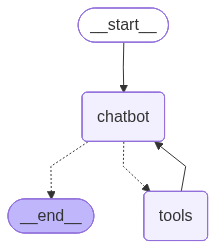

In [17]:
from langgraph.graph import StateGraph, START, END
from langgraph.prebuilt import ToolNode, tools_condition

tool_node = ToolNode(tools)

workflow = StateGraph(State)

workflow.add_node('chatbot', chatbot)
workflow.add_node('tools', tool_node)

workflow.add_edge(START, 'chatbot')
workflow.add_edge('tools', 'chatbot')
workflow.add_conditional_edges('chatbot', tools_condition)

graph = workflow.compile()
graph

### 그래프 실행 thread configuration

In [28]:
# user1 - 첫번째 대화
from langchain_core.messages import HumanMessage

user1_config = {'configurable': {'thread_id': 'user1'}}
user_input = '반갑다, 챗봇! 나는 쪼꼬오로라야!'
user1_state = {'messages': [HumanMessage(content=user_input)]}
user1_state = graph.invoke(user1_state, user1_config)
user1_state['messages'][-1].content

'반가워요, 쪼꼬오로라님! 무엇을 도와드릴까요? 😊'

In [29]:
# user1 - 두번째 대화
user_input = '내 이름은 뭐라고?'
user1_state = {'messages': [HumanMessage(content=user_input)]}
user1_state = graph.invoke(user1_state, user1_config)
user1_state['messages'][-1].content

'죄송하지만, 제가 접근할 수 있는 정보에는 사용자의 이름이 포함되어 있지 않습니다. 알려주지 않으셨다면, 당신의 이름을 알 수 없습니다. :)'

In [ ]:
# user2 - 첫번째 대화
user2_config = {'configurable': {'thread_id': 'user2'}}
user2_input = '반갑다, 챗봇! 내 이름을 알고 있어?'
user2_state = {'messages': [HumanMessage(content=user_input)]}
user2_state = graph.invoke(user2_state, config=user2_config)
user2_state['messages'][-1].content

In [ ]:
# user1 - 세번째 대화
user_input = '주말에 날시가 좋다고 하니, 놀러가자! 내 이름이 뭐라고?'
user1_state = {'messages': [HumanMessage(content=user_input)]}
user1_state = graph.invoke(user1_state, config=user1_config)
user1_state['messages'][-1].content


In [ ]:
user1_state